# MC1 Musical Influence Graph - Exploratory Data Analysis

## Overview
This notebook performs an exploratory data analysis of the VAST 2025 MC1 musical influence graph dataset.

**Dataset characteristics:**
- **File**: MC1_graph.json
- **Type**: Directed Multigraph  
- **Nodes**: 17,412
- **Edges**: 37,857
- **Connected Components**: 18
- **Node Types**: Person, Song, RecordLabel, Album, MusicalGroup
- **Edge Types**: 12 different relationship types

**Data Sources:**
- Crowdsourced musical influence repository
- Song popularity data from journalist Silas Reed


In [11]:
# Import required libraries
import json
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")


Libraries imported successfully!


In [12]:
# Load the graph data
print("Loading MC1_graph.json...")
with open('MC1_graph.json', 'r', encoding='utf-8') as f:
    graph_data = json.load(f)

# Convert to NetworkX graph
G = nx.node_link_graph(graph_data)

print(f"Graph loaded successfully!")
print(f"Number of nodes: {G.number_of_nodes():,}")
print(f"Number of edges: {G.number_of_edges():,}")
print(f"Is directed: {G.is_directed()}")
print(f"Is multigraph: {G.is_multigraph()}")
print(f"Number of connected components: {nx.number_weakly_connected_components(G)}")


Loading MC1_graph.json...
Graph loaded successfully!
Number of nodes: 17,412
Number of edges: 37,857
Is directed: True
Is multigraph: True
Number of connected components: 16


## 1. Node Analysis


Node Type Distribution:
------------------------------
         Person: 11,361 (65.2%)
           Song:  3,615 (20.8%)
    RecordLabel:  1,217 (7.0%)
          Album:    996 (5.7%)
   MusicalGroup:    223 (1.3%)


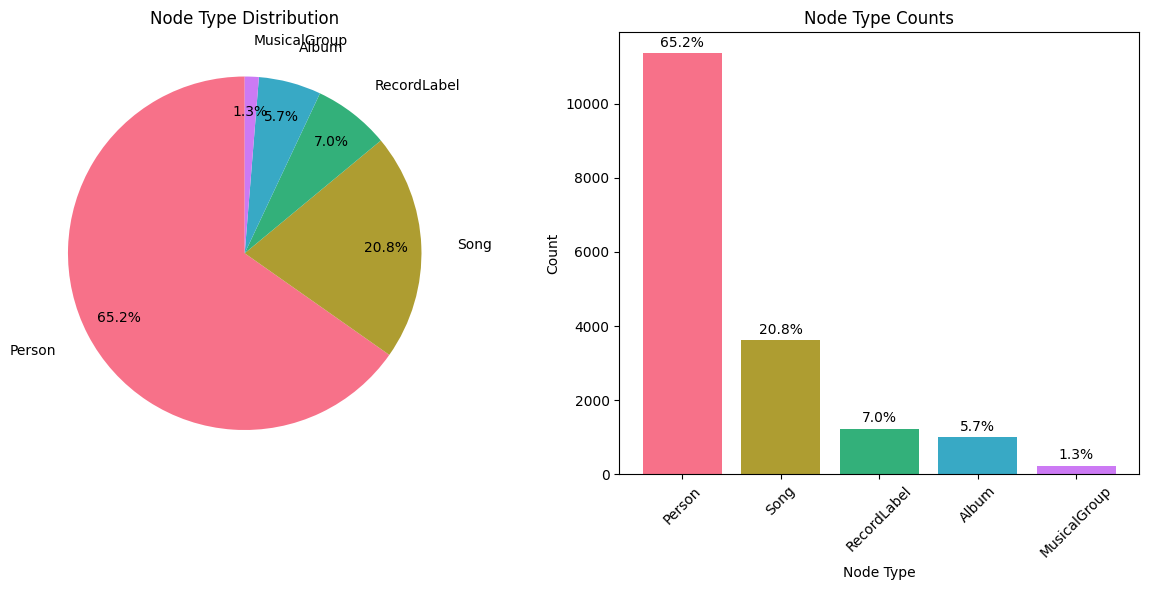

In [13]:
# Analyze node types
node_types = [G.nodes[node].get('Node Type', 'Unknown') for node in G.nodes()]
node_type_counts = Counter(node_types)

print("Node Type Distribution:")
print("-" * 30)
for node_type, count in node_type_counts.most_common():
    percentage = (count / len(node_types)) * 100
    print(f"{node_type:>15}: {count:>6,} ({percentage:.1f}%)")

# Visualize node type distribution
plt.figure(figsize=(12, 6))
types, counts = zip(*node_type_counts.most_common())
colors = sns.color_palette("husl", len(types))

plt.subplot(1, 2, 1)
# Increase figure size and adjust pie chart
plt.pie(counts, labels=types, autopct='%1.1f%%', colors=colors, startangle=90,
        labeldistance=1.2, pctdistance=0.8)  # Adjust label and percentage distances
plt.title('Node Type Distribution')

plt.subplot(1, 2, 2)
bars = plt.bar(types, counts, color=colors)
plt.title('Node Type Counts')
plt.xlabel('Node Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
for bar, count in zip(bars, counts):
    percentage = (count / sum(counts)) * 100
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, f'{percentage:.1f}%', 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [14]:
# Analyze Songs and Albums in detail
songs_and_albums = [node for node in G.nodes() if G.nodes[node].get('Node Type') in ['Song', 'Album']]

print(f"Total Songs and Albums: {len(songs_and_albums):,}")

# Extract detailed information
songs_albums_data = []
for node in songs_and_albums:
    node_data = G.nodes[node]
    songs_albums_data.append({
        'id': node,
        'type': node_data.get('Node Type'),
        'genre': node_data.get('genre'),
        'notable': node_data.get('notable', False),
        'release_date': node_data.get('release_date'),
        'notoriety_date': node_data.get('notoriety_date'),
        'written_date': node_data.get('written_date'),
        'single': node_data.get('single') if node_data.get('Node Type') == 'Song' else None
    })

df_songs_albums = pd.DataFrame(songs_albums_data)

print("\nSongs vs Albums:")
print(df_songs_albums['type'].value_counts())

print("\nNotable vs Non-Notable:")
print(df_songs_albums['notable'].value_counts())

print(f"\nNotable percentage: {(df_songs_albums['notable'].sum() / len(df_songs_albums)) * 100:.1f}%")


Total Songs and Albums: 4,611

Songs vs Albums:
type
Song     3615
Album     996
Name: count, dtype: int64

Notable vs Non-Notable:
notable
True     4297
False     314
Name: count, dtype: int64

Notable percentage: 93.2%


Genre Distribution:
--------------------
genre
Dream Pop               742
Indie Folk              450
Synthwave               382
Doom Metal              348
Oceanus Folk            305
Alternative Rock        258
Southern Gothic Rock    242
Indie Rock              208
Americana               184
Psychedelic Rock        172
Name: count, dtype: int64

Notable/Non-Notable Distribution:
--------------------
Songs:
Notable: 93.1%
Non-Notable: 6.9%

Albums:
Notable: 93.4%
Non-Notable: 6.6%

Singles Distribution (Songs only):
--------------------
Singles: 78.5%
Non-Singles: 21.5%


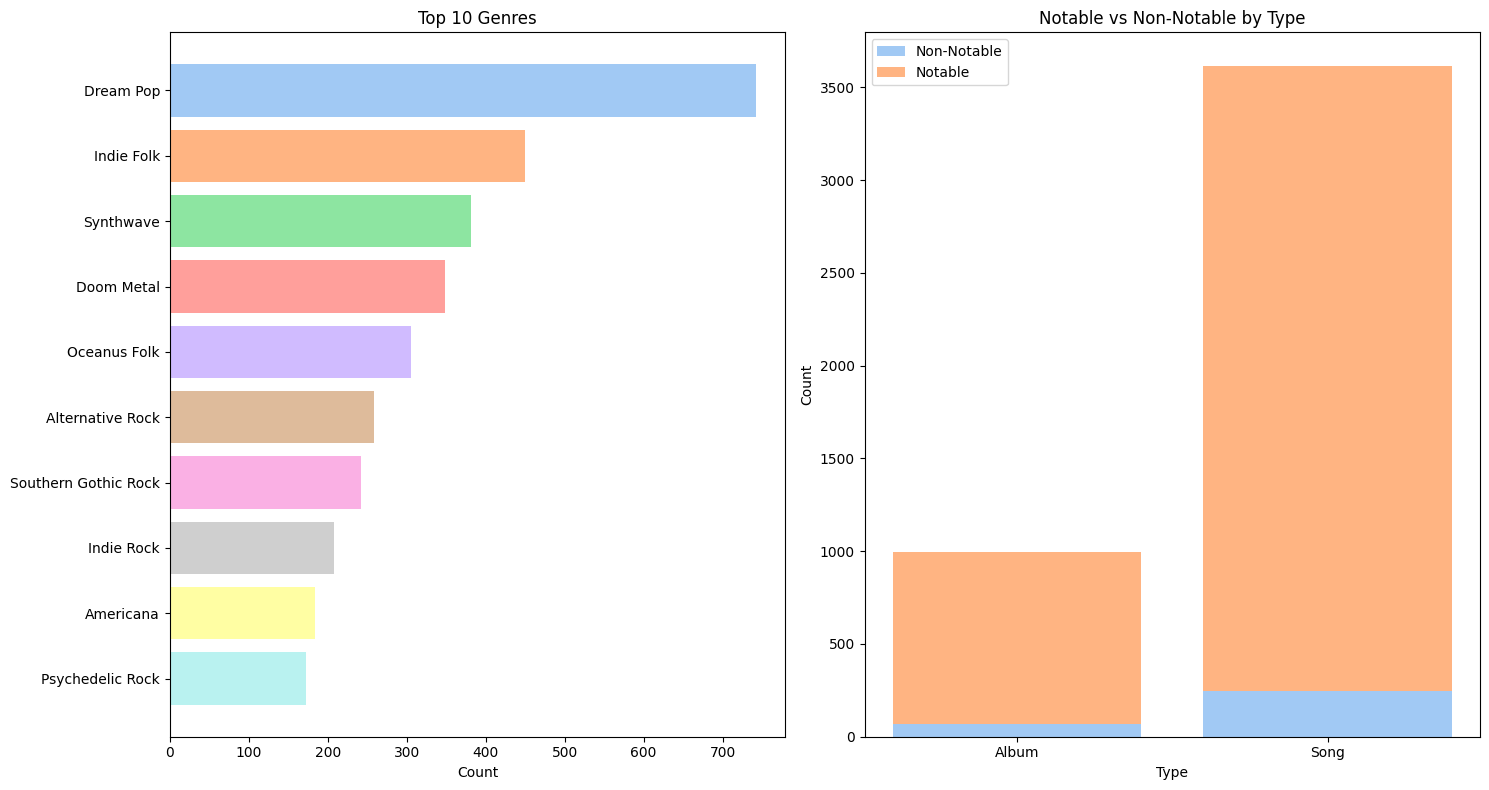

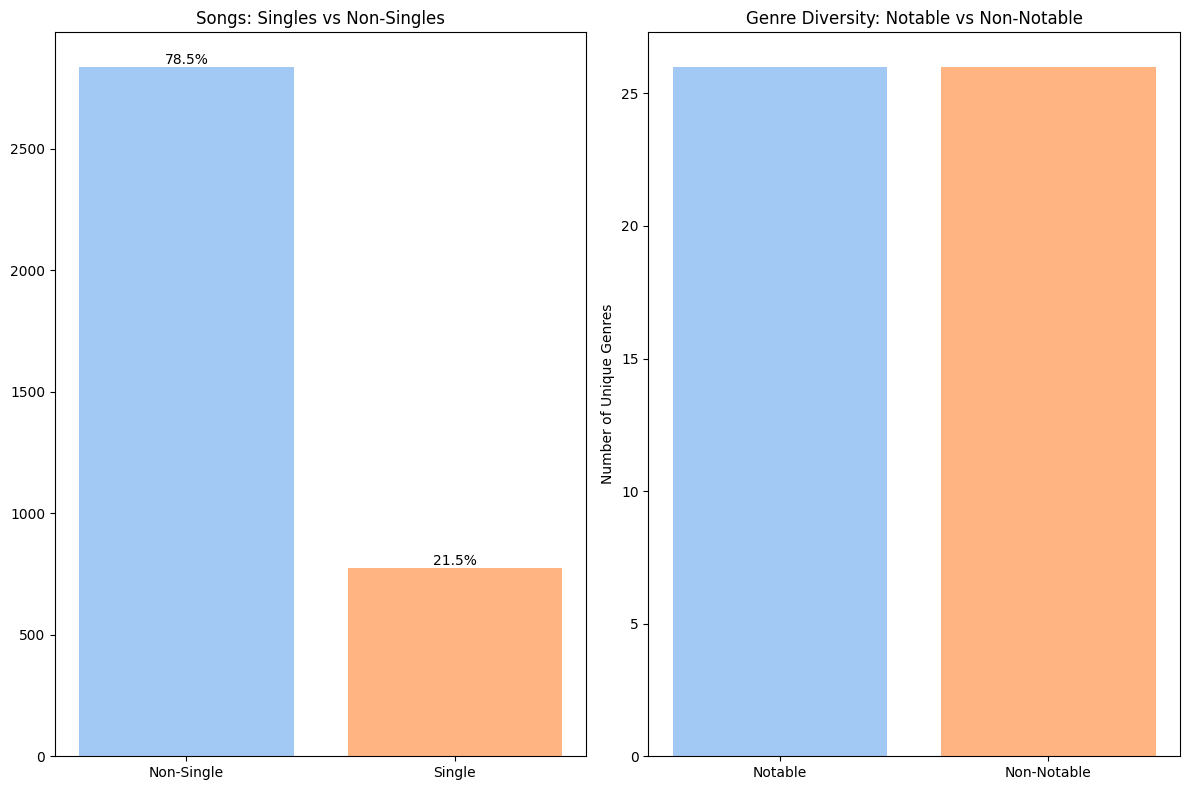

In [15]:
# Genre analysis
print("Genre Distribution:")
print("-" * 20)
genre_counts = df_songs_albums['genre'].value_counts()
print(genre_counts.head(10))

# Print notable/non-notable distribution for songs and albums
print("\nNotable/Non-Notable Distribution:")
print("-" * 20)
notable_dist = df_songs_albums.groupby(['type', 'notable']).size().unstack(fill_value=0)
notable_pct = notable_dist.div(notable_dist.sum(axis=1), axis=0) * 100
print("Songs:")
print(f"Notable: {notable_pct.loc['Song', True]:.1f}%")
print(f"Non-Notable: {notable_pct.loc['Song', False]:.1f}%")
print("\nAlbums:")
print(f"Notable: {notable_pct.loc['Album', True]:.1f}%") 
print(f"Non-Notable: {notable_pct.loc['Album', False]:.1f}%")

# Print singles distribution for songs
print("\nSingles Distribution (Songs only):")
print("-" * 20)
songs_only = df_songs_albums[df_songs_albums['type'] == 'Song']
singles_dist = songs_only['single'].value_counts(normalize=True) * 100
print(f"Singles: {singles_dist[True]:.1f}%")
print(f"Non-Singles: {singles_dist[False]:.1f}%")

# Visualize top genres
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
top_genres = genre_counts.head(10)
colors = sns.color_palette("pastel", len(top_genres))
plt.barh(range(len(top_genres)), top_genres.values, color=colors)
plt.yticks(range(len(top_genres)), top_genres.index)
plt.xlabel('Count')
plt.title('Top 10 Genres')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
# Notable vs non-notable by type
notable_by_type = df_songs_albums.groupby(['type', 'notable']).size().unstack(fill_value=0)
colors = sns.color_palette("pastel", 2)
bars = plt.bar(notable_by_type.index, notable_by_type[False], label='Non-Notable', color=colors[0])
plt.bar(notable_by_type.index, notable_by_type[True], bottom=notable_by_type[False], label='Notable', color=colors[1])
plt.title('Notable vs Non-Notable by Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend()

plt.tight_layout()
plt.show()

# Additional plots in separate figures
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
# Singles vs non-singles (for songs only) - using bar chart instead of pie
songs_only = df_songs_albums[df_songs_albums['type'] == 'Song']
if len(songs_only) > 0:
    single_counts = songs_only['single'].value_counts()
    colors = sns.color_palette("pastel", 2)
    plt.bar(['Non-Single', 'Single'], single_counts.values, color=colors)
    plt.title('Songs: Singles vs Non-Singles')
    # Add percentage labels on top of bars
    for i, v in enumerate(single_counts.values):
        percentage = (v / single_counts.sum()) * 100
        plt.text(i, v, f'{percentage:.1f}%', ha='center', va='bottom')

plt.subplot(1, 2, 2)
# Genre diversity for notable vs non-notable
notable_genres = df_songs_albums[df_songs_albums['notable'] == True]['genre'].nunique()
non_notable_genres = df_songs_albums[df_songs_albums['notable'] == False]['genre'].nunique()
colors = sns.color_palette("pastel", 2)
plt.bar(['Notable', 'Non-Notable'], [notable_genres, non_notable_genres], color=colors)
plt.ylabel('Number of Unique Genres')
plt.title('Genre Diversity: Notable vs Non-Notable')

plt.tight_layout()
plt.show()


## 2. Edge Analysis


Edge Type Distribution:
------------------------------
         PerformerOf: 13,587 (35.9%)
          RecordedBy:  3,798 (10.0%)
          ComposerOf:  3,290 (8.7%)
          ProducerOf:  3,209 (8.5%)
       DistributedBy:  3,013 (8.0%)
          LyricistOf:  2,985 (7.9%)
           InStyleOf:  2,289 (6.0%)
    InterpolatesFrom:  1,574 (4.2%)
  LyricalReferenceTo:  1,496 (4.0%)
             CoverOf:  1,429 (3.8%)
     DirectlySamples:    619 (1.6%)
            MemberOf:    568 (1.5%)


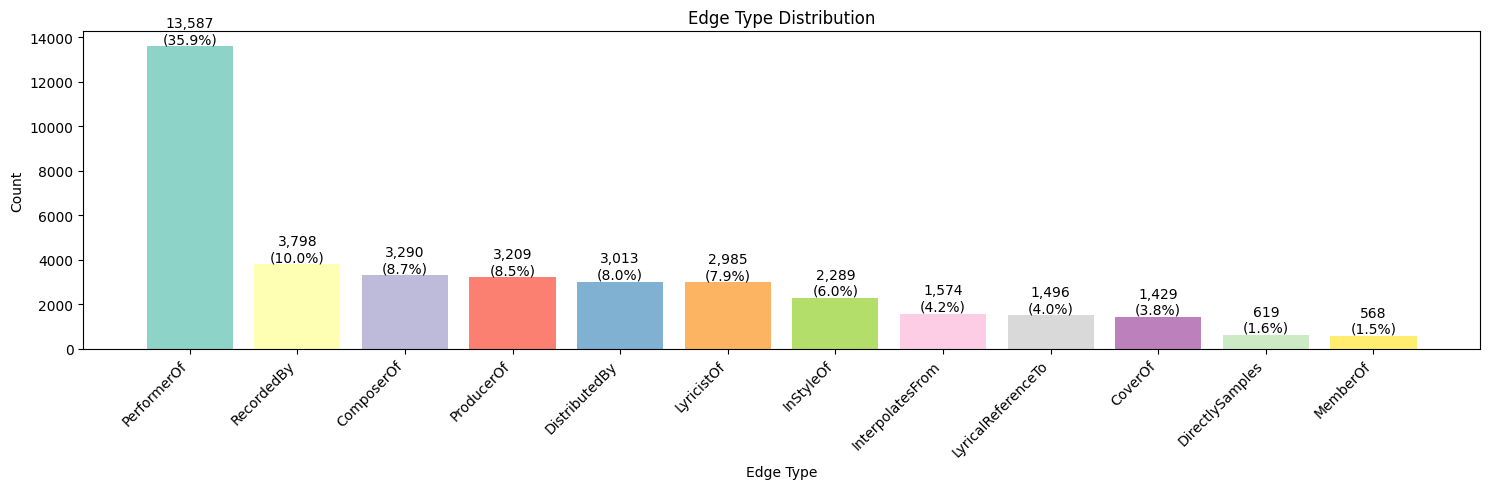

In [16]:
# Analyze edge types
edge_types = []
for u, v, d in G.edges(data=True):
    edge_types.append(d.get('Edge Type', 'Unknown'))

edge_type_counts = Counter(edge_types)

print("Edge Type Distribution:")
print("-" * 30)
for edge_type, count in edge_type_counts.most_common():
    percentage = (count / len(edge_types)) * 100
    print(f"{edge_type:>20}: {count:>6,} ({percentage:.1f}%)")

# Visualize edge type distribution
plt.figure(figsize=(15, 5))

types, counts = zip(*edge_type_counts.most_common())
colors = sns.color_palette("Set3", len(types))
bars = plt.bar(types, counts, color=colors)
plt.title('Edge Type Distribution')
plt.xlabel('Edge Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Add count and percentage labels on top of bars
total = sum(counts)
for bar, count in zip(bars, counts):
    percentage = (count/total) * 100
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             f'{count:,}\n({percentage:.1f}%)', 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()


Edge Categories:
--------------------
  Professional Roles: 23,071 (60.9%)
 Creative Influences:  7,407 (19.6%)
Business Relationships:  6,811 (18.0%)
          Membership:    568 (1.5%)


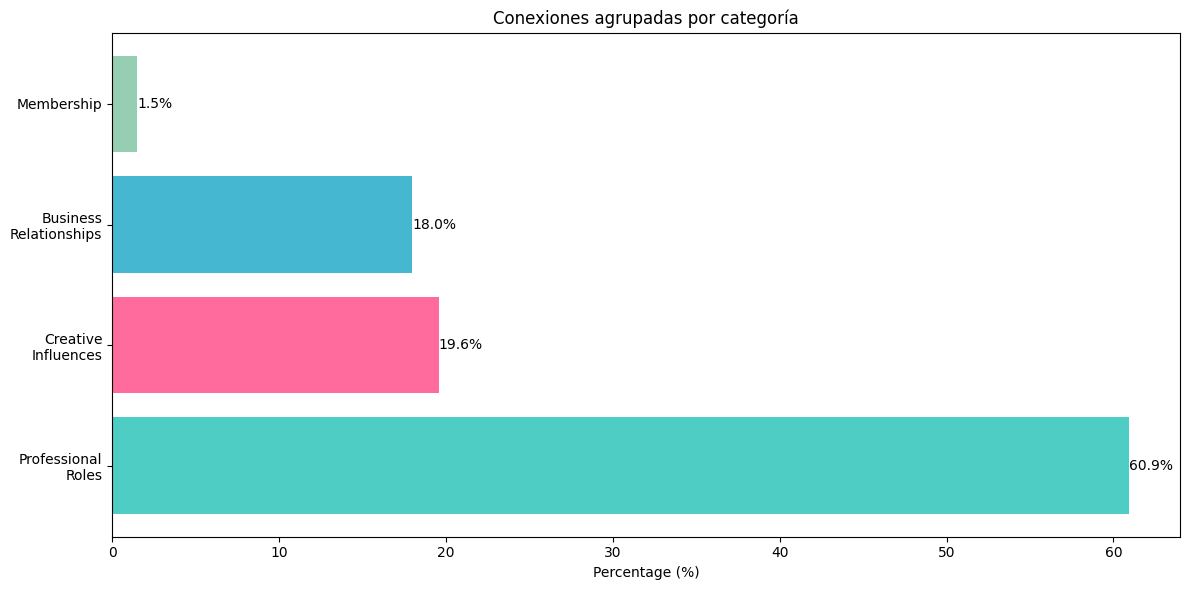

In [17]:
# Categorize edge types by function
creative_influences = ['InStyleOf', 'InterpolatesFrom', 'CoverOf', 'LyricalReferenceTo', 'DirectlySamples']
professional_roles = ['PerformerOf', 'ComposerOf', 'ProducerOf', 'LyricistOf']
business_relationships = ['RecordedBy', 'DistributedBy']
membership = ['MemberOf']

# Count edges by category
creative_count = sum(edge_type_counts[edge_type] for edge_type in creative_influences)
professional_count = sum(edge_type_counts[edge_type] for edge_type in professional_roles)
business_count = sum(edge_type_counts[edge_type] for edge_type in business_relationships)
membership_count = sum(edge_type_counts[edge_type] for edge_type in membership)

# Create lists and sort by count
categories = ['Creative\nInfluences', 'Professional\nRoles', 'Business\nRelationships', 'Membership']
category_counts = [creative_count, professional_count, business_count, membership_count]
colors = ['#FF6B9D', '#4ECDC4', '#45B7D1', '#96CEB4']

# Sort all lists based on counts in reverse order
sorted_indices = sorted(range(len(category_counts)), key=lambda k: category_counts[k], reverse=True)
categories = [categories[i] for i in sorted_indices]
category_counts = [category_counts[i] for i in sorted_indices]
colors = [colors[i] for i in sorted_indices]

print("Edge Categories:")
print("-" * 20)
for cat, count in zip(categories, category_counts):
    percentage = (count / sum(category_counts)) * 100
    cat_formatted = cat.replace('\n', ' ')
    print(f"{cat_formatted:>20}: {count:>6,} ({percentage:.1f}%)")

# Visualize categories
plt.figure(figsize=(12, 6))

total = sum(category_counts)
percentages = [count/total * 100 for count in category_counts]
bars = plt.barh(categories, percentages, color=colors)
plt.title('Conexiones agrupadas por categoría')
plt.xlabel('Percentage (%)')

# Add percentage labels
for bar, pct in zip(bars, percentages):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{pct:.1f}%',
             ha='left', va='center')

plt.tight_layout()
plt.show()


## 3. Temporal Analysis


Songs/Albums with valid release years: 4,611
Release year range: 1975 - 2040

Songs/Albums with both release and notoriety dates: 649
Average time to notoriety: 0.4 years
Median time to notoriety: 0.0 years


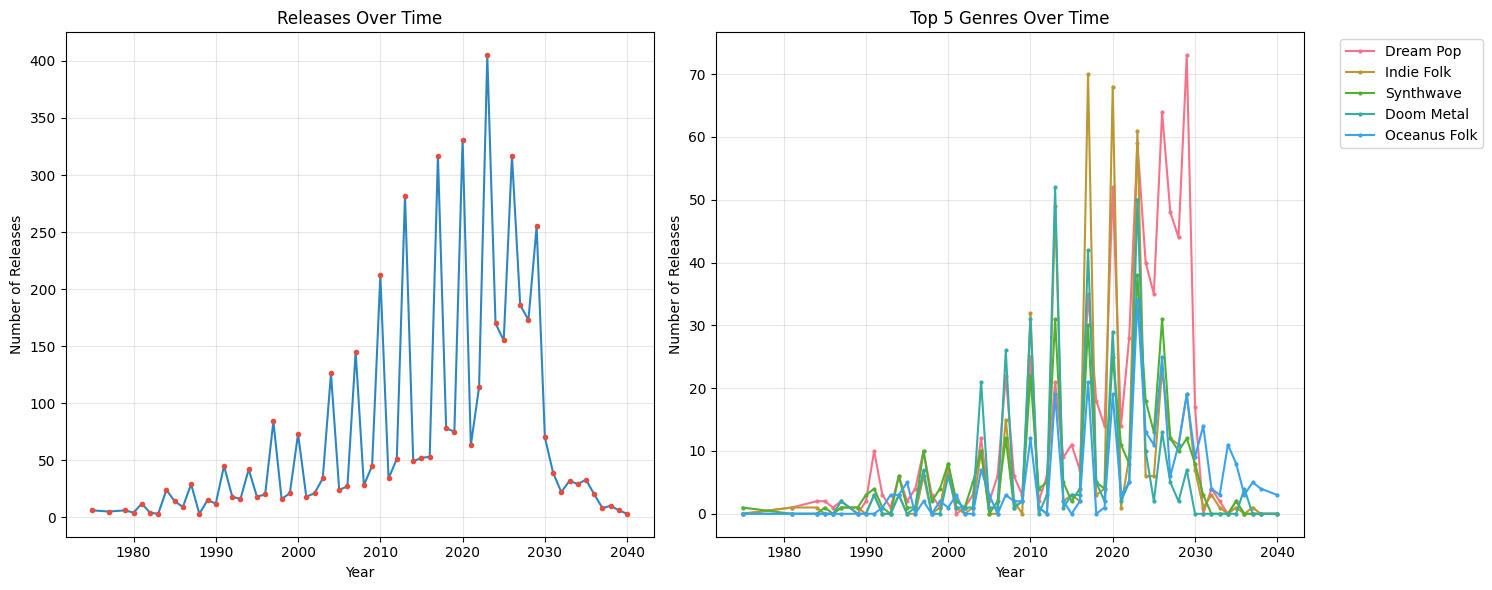

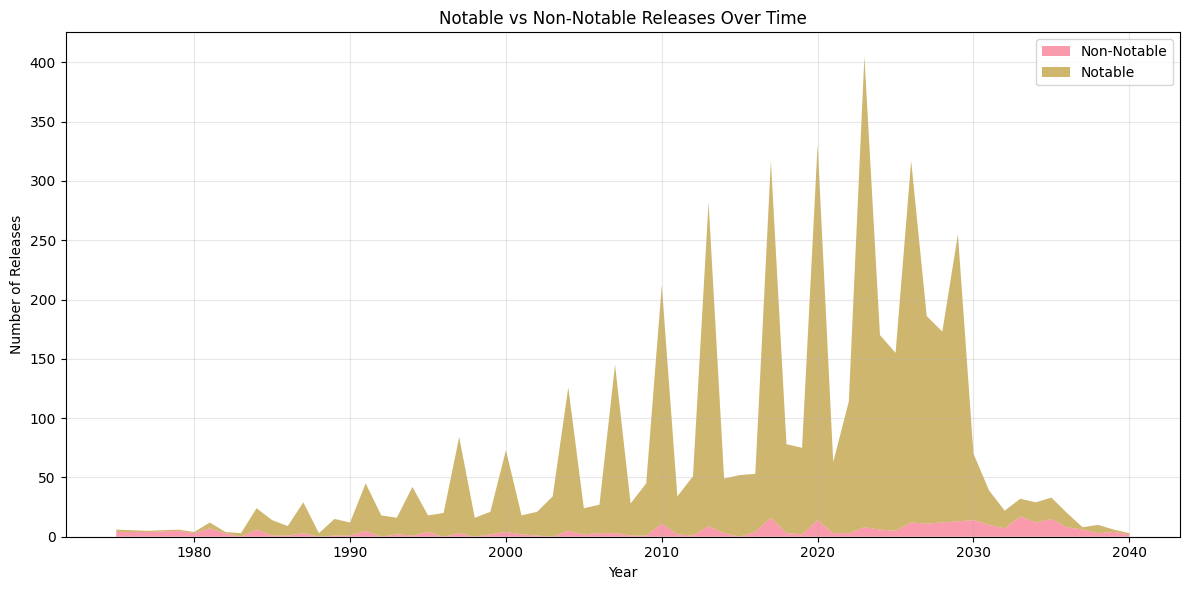

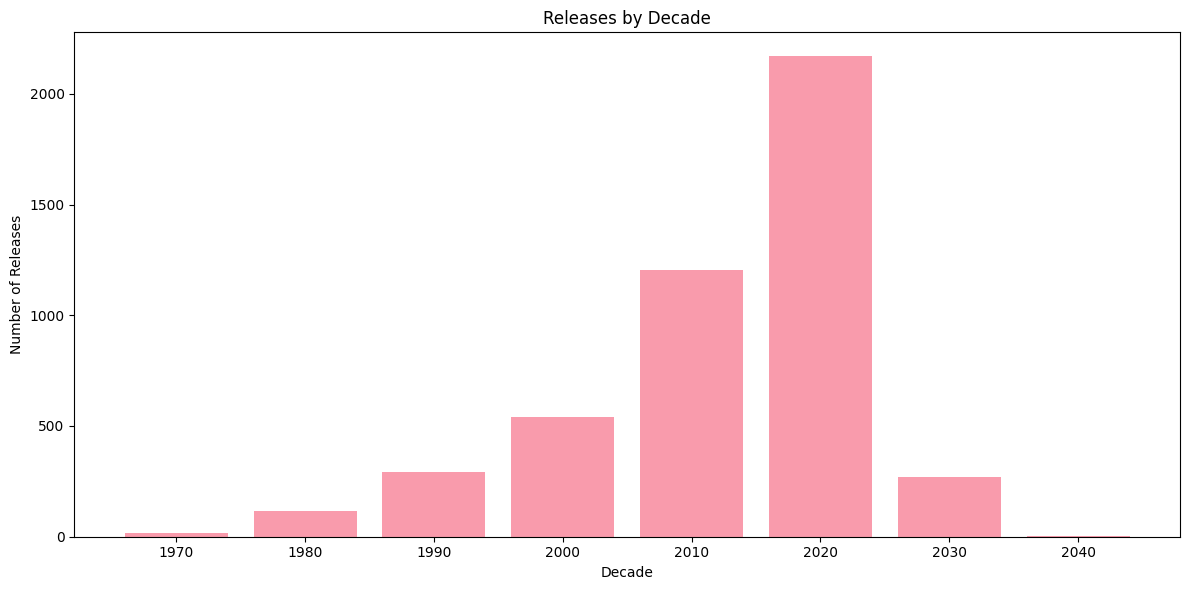

In [18]:
# Temporal analysis of releases
df_songs_albums['release_year'] = pd.to_numeric(df_songs_albums['release_date'], errors='coerce')
df_songs_albums['notoriety_year'] = pd.to_numeric(df_songs_albums['notoriety_date'], errors='coerce')

# Filter out invalid years
valid_releases = df_songs_albums.dropna(subset=['release_year'])
print(f"Songs/Albums with valid release years: {len(valid_releases):,}")
print(f"Release year range: {valid_releases['release_year'].min():.0f} - {valid_releases['release_year'].max():.0f}")

# Time to notoriety analysis
notable_with_both_dates = df_songs_albums.dropna(subset=['release_year', 'notoriety_year'])
if len(notable_with_both_dates) > 0:
    notable_with_both_dates['time_to_notoriety'] = notable_with_both_dates['notoriety_year'] - notable_with_both_dates['release_year']
    print(f"\nSongs/Albums with both release and notoriety dates: {len(notable_with_both_dates):,}")
    print(f"Average time to notoriety: {notable_with_both_dates['time_to_notoriety'].mean():.1f} years")
    print(f"Median time to notoriety: {notable_with_both_dates['time_to_notoriety'].median():.1f} years")

# Releases over time and top 5 genres plot
plt.figure(figsize=(15, 6))

# Release timeline
plt.subplot(1, 2, 1)
release_counts = valid_releases['release_year'].value_counts().sort_index()
plt.plot(release_counts.index, release_counts.values, color='#2E86C1', marker='o', markersize=3, markerfacecolor='#E74C3C', markeredgecolor='#E74C3C')
plt.title('Releases Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Releases')
plt.grid(True, alpha=0.3)

# Genre evolution over time (top 5 genres)
plt.subplot(1, 2, 2)
top_5_genres = genre_counts.head(5).index
genre_year_data = valid_releases[valid_releases['genre'].isin(top_5_genres)]
genre_timeline = genre_year_data.groupby(['release_year', 'genre']).size().unstack(fill_value=0)
for genre in top_5_genres:
    if genre in genre_timeline.columns:
        plt.plot(genre_timeline.index, genre_timeline[genre], marker='o', label=genre, markersize=2)
plt.title('Top 5 Genres Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Releases')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Notable vs non-notable plot
plt.figure(figsize=(12, 6))
notable_by_year = valid_releases.groupby(['release_year', 'notable']).size().unstack(fill_value=0)
if False in notable_by_year.columns and True in notable_by_year.columns:
    plt.stackplot(notable_by_year.index, notable_by_year[False], notable_by_year[True], 
                  labels=['Non-Notable', 'Notable'], alpha=0.7)
    plt.title('Notable vs Non-Notable Releases Over Time')
    plt.xlabel('Year')
    plt.ylabel('Number of Releases')
    plt.legend()
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Release decade analysis plot
plt.figure(figsize=(12, 6))
valid_releases['decade'] = (valid_releases['release_year'] // 10) * 10
decade_counts = valid_releases['decade'].value_counts().sort_index()
plt.bar(decade_counts.index, decade_counts.values, width=8, alpha=0.7)
plt.title('Releases by Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Releases')
plt.xticks(decade_counts.index)
plt.tight_layout()
plt.show()


## 4. Network Structure Analysis


Network Structure Analysis:
------------------------------
Number of nodes: 17,412
Number of edges: 37,857
Density: 0.000125

Connected Components:
Weakly connected components: 16
Strongly connected components: 17411
Largest weakly connected component: 17,277 nodes (99.2%)
Largest strongly connected component: 2 nodes (0.0%)


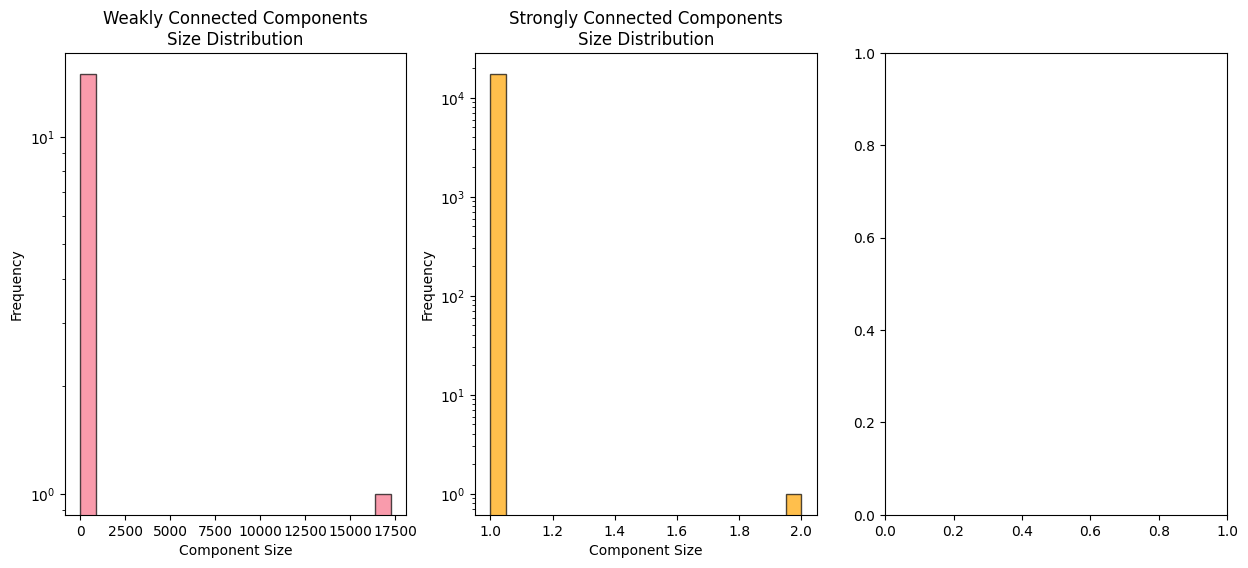

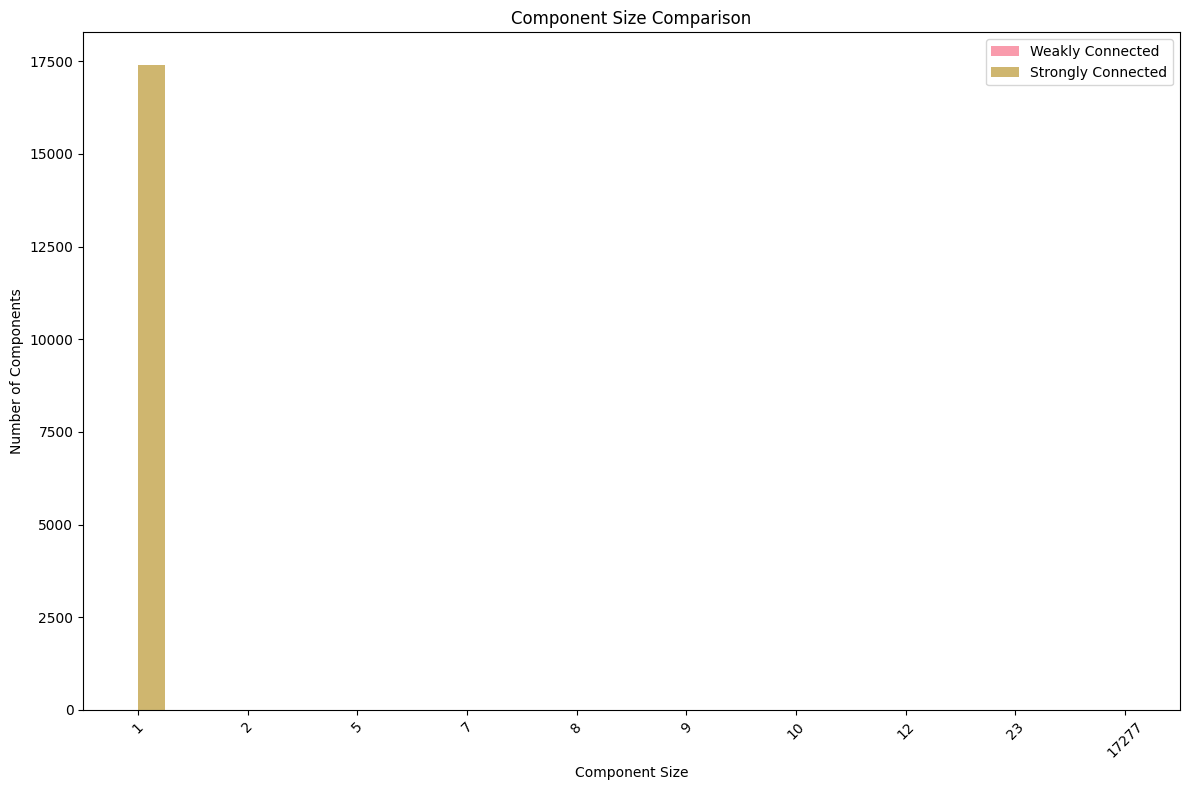

In [19]:
# Network structure analysis
print("Network Structure Analysis:")
print("-" * 30)

# Basic metrics
print(f"Number of nodes: {G.number_of_nodes():,}")
print(f"Number of edges: {G.number_of_edges():,}")
print(f"Density: {nx.density(G):.6f}")

# Connected components
weakly_connected = list(nx.weakly_connected_components(G))
strongly_connected = list(nx.strongly_connected_components(G))

print(f"\nConnected Components:")
print(f"Weakly connected components: {len(weakly_connected)}")
print(f"Strongly connected components: {len(strongly_connected)}")

# Largest components
largest_wcc_size = len(max(weakly_connected, key=len))
largest_scc_size = len(max(strongly_connected, key=len))

print(f"Largest weakly connected component: {largest_wcc_size:,} nodes ({(largest_wcc_size/G.number_of_nodes())*100:.1f}%)")
print(f"Largest strongly connected component: {largest_scc_size:,} nodes ({(largest_scc_size/G.number_of_nodes())*100:.1f}%)")

# Component size distribution
wcc_sizes = [len(comp) for comp in weakly_connected]
scc_sizes = [len(comp) for comp in strongly_connected]

plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.hist(wcc_sizes, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Component Size')
plt.ylabel('Frequency')
plt.title('Weakly Connected Components\nSize Distribution')
plt.yscale('log')

plt.subplot(1, 3, 2)
plt.hist(scc_sizes, bins=20, alpha=0.7, edgecolor='black', color='orange')
plt.xlabel('Component Size')
plt.ylabel('Frequency')
plt.title('Strongly Connected Components\nSize Distribution')
plt.yscale('log')

plt.subplot(1, 3, 3)
sizes_comparison = pd.DataFrame({
    'Weakly Connected': pd.Series(wcc_sizes).value_counts().sort_index(),
    'Strongly Connected': pd.Series(scc_sizes).value_counts().sort_index()
}).fillna(0)
sizes_comparison.plot(kind='bar', alpha=0.7)
plt.xlabel('Component Size')
plt.ylabel('Number of Components')
plt.title('Component Size Comparison')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


Degree Statistics:
--------------------
In-degree  - Mean: 2.17, Median: 0.0, Max: 224
Out-degree - Mean: 2.17, Median: 2.0, Max: 52
Total degree - Mean: 4.35, Median: 2.0, Max: 224

Top 10 Nodes by In-Degree:
  Echo Chamber Records (RecordLabel): 224
  Kamiogawa Rhythms (RecordLabel): 157
  Whispers of Finality (Song): 151
  Ripples and Whispers (Song): 148
  99Ascent (RecordLabel): 98
  Mucambo Groove (RecordLabel): 96
  Mercy's Endless Tide (Song): 80
  Collective Harmony (RecordLabel): 74
  Colline-Cascade Studios (RecordLabel): 71
  Adra Amplify (RecordLabel): 69

Top 10 Nodes by Out-Degree:
  Sailor Shift (Person): 52
  Szymon Pyć (Person): 49
  Jay Walters (Person): 47
  Kimberly Snyder (Person): 42
  Rising From the Shadows (Song): 38
  Oceanic Records (RecordLabel): 38
  Ping Tian (Person): 37
  Angelika Osojca (Person): 36
  Quattro Voci (MusicalGroup): 34
  Megan Bennett (Person): 33


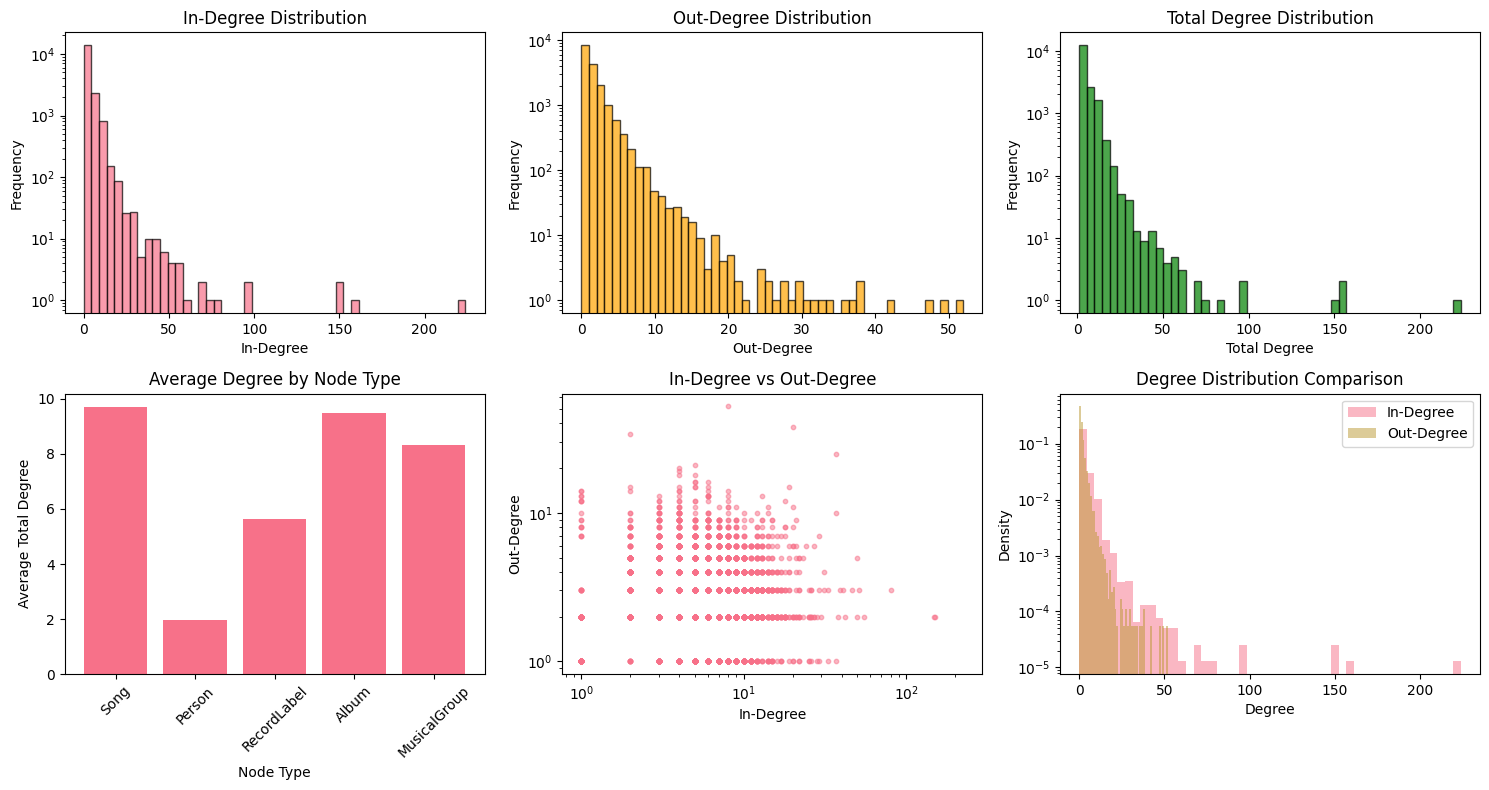

In [20]:
# Degree analysis
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())
total_degrees = dict(G.degree())

in_degree_values = list(in_degrees.values())
out_degree_values = list(out_degrees.values())
total_degree_values = list(total_degrees.values())

print("Degree Statistics:")
print("-" * 20)
print(f"In-degree  - Mean: {np.mean(in_degree_values):.2f}, Median: {np.median(in_degree_values):.1f}, Max: {max(in_degree_values)}")
print(f"Out-degree - Mean: {np.mean(out_degree_values):.2f}, Median: {np.median(out_degree_values):.1f}, Max: {max(out_degree_values)}")
print(f"Total degree - Mean: {np.mean(total_degree_values):.2f}, Median: {np.median(total_degree_values):.1f}, Max: {max(total_degree_values)}")

# Find high-degree nodes
top_in_degree = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
top_out_degree = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 Nodes by In-Degree:")
for node, degree in top_in_degree:
    node_type = G.nodes[node].get('Node Type', 'Unknown')
    name = G.nodes[node].get('name', 'Unknown')
    print(f"  {name} ({node_type}): {degree}")

print("\nTop 10 Nodes by Out-Degree:")
for node, degree in top_out_degree:
    node_type = G.nodes[node].get('Node Type', 'Unknown')
    name = G.nodes[node].get('name', 'Unknown')
    print(f"  {name} ({node_type}): {degree}")

# Visualize degree distributions
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
plt.hist(in_degree_values, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('In-Degree')
plt.ylabel('Frequency')
plt.title('In-Degree Distribution')
plt.yscale('log')

plt.subplot(2, 3, 2)
plt.hist(out_degree_values, bins=50, alpha=0.7, edgecolor='black', color='orange')
plt.xlabel('Out-Degree')
plt.ylabel('Frequency')
plt.title('Out-Degree Distribution')
plt.yscale('log')

plt.subplot(2, 3, 3)
plt.hist(total_degree_values, bins=50, alpha=0.7, edgecolor='black', color='green')
plt.xlabel('Total Degree')
plt.ylabel('Frequency')
plt.title('Total Degree Distribution')
plt.yscale('log')

# Degree by node type
plt.subplot(2, 3, 4)
node_type_degrees = {}
for node in G.nodes():
    node_type = G.nodes[node].get('Node Type', 'Unknown')
    if node_type not in node_type_degrees:
        node_type_degrees[node_type] = []
    node_type_degrees[node_type].append(total_degrees[node])

type_avg_degrees = {k: np.mean(v) for k, v in node_type_degrees.items()}
plt.bar(type_avg_degrees.keys(), type_avg_degrees.values())
plt.xlabel('Node Type')
plt.ylabel('Average Total Degree')
plt.title('Average Degree by Node Type')
plt.xticks(rotation=45)

# In vs Out degree scatter
plt.subplot(2, 3, 5)
plt.scatter(in_degree_values, out_degree_values, alpha=0.5, s=10)
plt.xlabel('In-Degree')
plt.ylabel('Out-Degree')
plt.title('In-Degree vs Out-Degree')
plt.xscale('log')
plt.yscale('log')

# Degree distribution comparison
plt.subplot(2, 3, 6)
plt.hist(in_degree_values, bins=50, alpha=0.5, label='In-Degree', density=True)
plt.hist(out_degree_values, bins=50, alpha=0.5, label='Out-Degree', density=True)
plt.xlabel('Degree')
plt.ylabel('Density')
plt.title('Degree Distribution Comparison')
plt.legend()
plt.yscale('log')

plt.tight_layout()
plt.show()


## 5. Influence and Success Analysis


In [21]:
creative_influences

['InStyleOf',
 'InterpolatesFrom',
 'CoverOf',
 'LyricalReferenceTo',
 'DirectlySamples']

Total creative influence relationships: 7,407
Creative influence subgraph - Nodes: 4,478, Edges: 7,407

Creative Influence Analysis:
------------------------------
Notable works - Influences received: 7,118
Notable works - Influences given: 7,028
Non-notable works - Influences received: 222
Non-notable works - Influences given: 312

Influence Rates (per work):
Notable works - Avg influences received: 1.66
Notable works - Avg influences given: 1.64
Non-notable works - Avg influences received: 0.71
Non-notable works - Avg influences given: 0.99


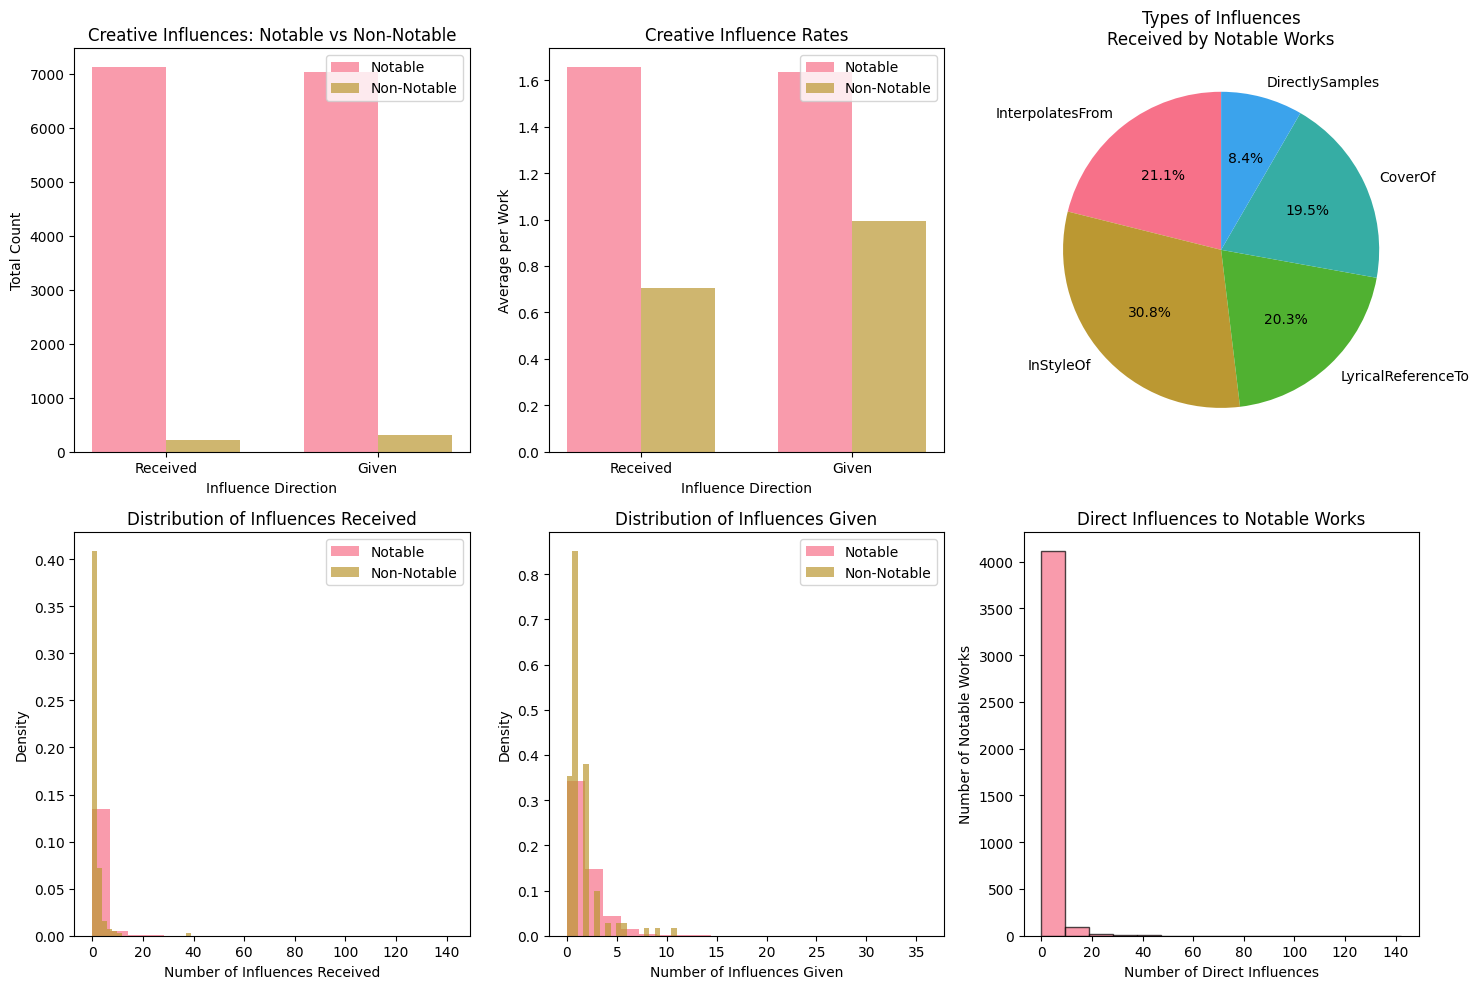

In [22]:
# Analyze relationship between influence and success
# Focus on creative influence edges
creative_influence_edges = []
for u, v, d in G.edges(data=True):
    if d.get('Edge Type') in creative_influences:
        creative_influence_edges.append((u, v, d.get('Edge Type')))

print(f"Total creative influence relationships: {len(creative_influence_edges):,}")

# Create subgraph with only creative influences
creative_subgraph = nx.DiGraph()
for u, v, edge_type in creative_influence_edges:
    creative_subgraph.add_edge(u, v, EdgeType=edge_type)

print(f"Creative influence subgraph - Nodes: {creative_subgraph.number_of_nodes():,}, Edges: {creative_subgraph.number_of_edges():,}")

# Analyze influence patterns for notable vs non-notable works
notable_songs_albums = set(df_songs_albums[df_songs_albums['notable'] == True]['id'])
non_notable_songs_albums = set(df_songs_albums[df_songs_albums['notable'] == False]['id'])

# Count influences received and given
notable_influences_received = 0
notable_influences_given = 0
non_notable_influences_received = 0
non_notable_influences_given = 0

for u, v, edge_type in creative_influence_edges:
    # Influences received
    if v in notable_songs_albums:
        notable_influences_received += 1
    elif v in non_notable_songs_albums:
        non_notable_influences_received += 1
    
    # Influences given
    if u in notable_songs_albums:
        notable_influences_given += 1
    elif u in non_notable_songs_albums:
        non_notable_influences_given += 1

print("\nCreative Influence Analysis:")
print("-" * 30)
print(f"Notable works - Influences received: {notable_influences_received:,}")
print(f"Notable works - Influences given: {notable_influences_given:,}")
print(f"Non-notable works - Influences received: {non_notable_influences_received:,}")
print(f"Non-notable works - Influences given: {non_notable_influences_given:,}")

# Calculate rates
notable_count = len(notable_songs_albums)
non_notable_count = len(non_notable_songs_albums)

print(f"\nInfluence Rates (per work):")
print(f"Notable works - Avg influences received: {notable_influences_received/notable_count:.2f}")
print(f"Notable works - Avg influences given: {notable_influences_given/notable_count:.2f}")
print(f"Non-notable works - Avg influences received: {non_notable_influences_received/non_notable_count:.2f}")
print(f"Non-notable works - Avg influences given: {non_notable_influences_given/non_notable_count:.2f}")

# Visualize influence patterns
plt.figure(figsize=(15, 10))

# Influence counts comparison
plt.subplot(2, 3, 1)
categories = ['Received', 'Given']
notable_values = [notable_influences_received, notable_influences_given]
non_notable_values = [non_notable_influences_received, non_notable_influences_given]

x = np.arange(len(categories))
width = 0.35

plt.bar(x - width/2, notable_values, width, label='Notable', alpha=0.7)
plt.bar(x + width/2, non_notable_values, width, label='Non-Notable', alpha=0.7)
plt.xlabel('Influence Direction')
plt.ylabel('Total Count')
plt.title('Creative Influences: Notable vs Non-Notable')
plt.xticks(x, categories)
plt.legend()

# Influence rates comparison
plt.subplot(2, 3, 2)
notable_rates = [notable_influences_received/notable_count, notable_influences_given/notable_count]
non_notable_rates = [non_notable_influences_received/non_notable_count, non_notable_influences_given/non_notable_count]

plt.bar(x - width/2, notable_rates, width, label='Notable', alpha=0.7)
plt.bar(x + width/2, non_notable_rates, width, label='Non-Notable', alpha=0.7)
plt.xlabel('Influence Direction')
plt.ylabel('Average per Work')
plt.title('Creative Influence Rates')
plt.xticks(x, categories)
plt.legend()

# Influence type breakdown for notable works
plt.subplot(2, 3, 3)
notable_influence_types = defaultdict(int)
for u, v, edge_type in creative_influence_edges:
    if v in notable_songs_albums:  # influences received by notable works
        notable_influence_types[edge_type] += 1

if notable_influence_types:
    types, counts = zip(*notable_influence_types.items())
    plt.pie(counts, labels=types, autopct='%1.1f%%', startangle=90)
    plt.title('Types of Influences\nReceived by Notable Works')

# Distribution of influences per work
plt.subplot(2, 3, 4)
notable_in_degrees = [creative_subgraph.in_degree(node) for node in notable_songs_albums if node in creative_subgraph]
non_notable_in_degrees = [creative_subgraph.in_degree(node) for node in non_notable_songs_albums if node in creative_subgraph]

plt.hist(notable_in_degrees, bins=20, alpha=0.7, label='Notable', density=True)
plt.hist(non_notable_in_degrees, bins=20, alpha=0.7, label='Non-Notable', density=True)
plt.xlabel('Number of Influences Received')
plt.ylabel('Density')
plt.title('Distribution of Influences Received')
plt.legend()

plt.subplot(2, 3, 5)
notable_out_degrees = [creative_subgraph.out_degree(node) for node in notable_songs_albums if node in creative_subgraph]
non_notable_out_degrees = [creative_subgraph.out_degree(node) for node in non_notable_songs_albums if node in creative_subgraph]

plt.hist(notable_out_degrees, bins=20, alpha=0.7, label='Notable', density=True)
plt.hist(non_notable_out_degrees, bins=20, alpha=0.7, label='Non-Notable', density=True)
plt.xlabel('Number of Influences Given')
plt.ylabel('Density')
plt.title('Distribution of Influences Given')
plt.legend()

# Success cascade analysis
plt.subplot(2, 3, 6)
# Find chains of influence leading to notable works
influence_chains = []
for notable_work in notable_songs_albums:
    if notable_work in creative_subgraph:
        predecessors = list(creative_subgraph.predecessors(notable_work))
        influence_chains.append(len(predecessors))

if influence_chains:
    plt.hist(influence_chains, bins=15, alpha=0.7, edgecolor='black')
    plt.xlabel('Number of Direct Influences')
    plt.ylabel('Number of Notable Works')
    plt.title('Direct Influences to Notable Works')

plt.tight_layout()
plt.show()


## 6. Key Findings and Summary


In [23]:
# Summary statistics and key insights
print("🎵 MC1 MUSICAL INFLUENCE GRAPH - KEY FINDINGS 🎵")
print("=" * 60)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   • Total nodes: {G.number_of_nodes():,}")
print(f"   • Total edges: {G.number_of_edges():,}")
print(f"   • Network density: {nx.density(G):.6f}")
print(f"   • Connected components: {nx.number_weakly_connected_components(G)}")

print(f"\n🎭 NODE COMPOSITION:")
for node_type, count in node_type_counts.most_common():
    percentage = (count / len(node_types)) * 100
    print(f"   • {node_type}: {count:,} ({percentage:.1f}%)")

print(f"\n🔗 RELATIONSHIP TYPES:")
for edge_type, count in edge_type_counts.most_common()[:5]:
    percentage = (count / len(edge_types)) * 100
    print(f"   • {edge_type}: {count:,} ({percentage:.1f}%)")

print(f"\n⭐ SUCCESS METRICS:")
total_works = len(df_songs_albums)
notable_works = df_songs_albums['notable'].sum()
print(f"   • Total songs/albums: {total_works:,}")
print(f"   • Notable works: {notable_works:,} ({(notable_works/total_works)*100:.1f}%)")

if len(notable_with_both_dates) > 0:
    avg_time_to_notoriety = notable_with_both_dates['time_to_notoriety'].mean()
    print(f"   • Average time to notoriety: {avg_time_to_notoriety:.1f} years")

print(f"\n🎨 CREATIVE INFLUENCES:")
print(f"   • Total creative influence relationships: {len(creative_influence_edges):,}")
print(f"   • Notable works avg influences received: {notable_influences_received/notable_count:.2f}")
print(f"   • Non-notable works avg influences received: {non_notable_influences_received/non_notable_count:.2f}")

print(f"\n🏆 TOP GENRES:")
for i, (genre, count) in enumerate(genre_counts.head(5).items(), 1):
    percentage = (count / len(df_songs_albums)) * 100
    print(f"   {i}. {genre}: {count:,} ({percentage:.1f}%)")

print(f"\n🌟 NETWORK INSIGHTS:")
largest_wcc = len(max(weakly_connected, key=len))
print(f"   • Largest connected component: {largest_wcc:,} nodes ({(largest_wcc/G.number_of_nodes())*100:.1f}%)")
print(f"   • Average in-degree: {np.mean(in_degree_values):.2f}")
print(f"   • Average out-degree: {np.mean(out_degree_values):.2f}")

print(f"\n💡 KEY RESEARCH DIRECTIONS:")
print(f"   • Influence propagation patterns across {len(creative_influences)} creative relationship types")
print(f"   • Success prediction based on network position and influence patterns")
print(f"   • Temporal evolution of genre popularity and cross-genre influences")
print(f"   • Identification of keystone nodes in the influence network")

print("\n" + "=" * 60)


🎵 MC1 MUSICAL INFLUENCE GRAPH - KEY FINDINGS 🎵

📊 DATASET OVERVIEW:
   • Total nodes: 17,412
   • Total edges: 37,857
   • Network density: 0.000125
   • Connected components: 16

🎭 NODE COMPOSITION:
   • Person: 11,361 (65.2%)
   • Song: 3,615 (20.8%)
   • RecordLabel: 1,217 (7.0%)
   • Album: 996 (5.7%)
   • MusicalGroup: 223 (1.3%)

🔗 RELATIONSHIP TYPES:
   • PerformerOf: 13,587 (35.9%)
   • RecordedBy: 3,798 (10.0%)
   • ComposerOf: 3,290 (8.7%)
   • ProducerOf: 3,209 (8.5%)
   • DistributedBy: 3,013 (8.0%)

⭐ SUCCESS METRICS:
   • Total songs/albums: 4,611
   • Notable works: 4,297 (93.2%)
   • Average time to notoriety: 0.4 years

🎨 CREATIVE INFLUENCES:
   • Total creative influence relationships: 7,407
   • Notable works avg influences received: 1.66
   • Non-notable works avg influences received: 0.71

🏆 TOP GENRES:
   1. Dream Pop: 742 (16.1%)
   2. Indie Folk: 450 (9.8%)
   3. Synthwave: 382 (8.3%)
   4. Doom Metal: 348 (7.5%)
   5. Oceanus Folk: 305 (6.6%)

🌟 NETWORK INSIGHT

In [24]:
# Save processed data for future analysis
print("Saving processed datasets for future analysis...")

# Save key datasets
df_songs_albums.to_csv('songs_albums_analysis.csv', index=False)
print("✅ Songs and albums data saved to 'songs_albums_analysis.csv'")

# Save network metrics
network_metrics = {
    'node_count': G.number_of_nodes(),
    'edge_count': G.number_of_edges(),
    'density': nx.density(G),
    'weakly_connected_components': len(weakly_connected),
    'strongly_connected_components': len(strongly_connected),
    'largest_wcc_size': largest_wcc_size,
    'largest_scc_size': largest_scc_size
}

import json
with open('network_metrics.json', 'w') as f:
    json.dump(network_metrics, f, indent=2)
print("✅ Network metrics saved to 'network_metrics.json'")

# Save edge type analysis
edge_analysis = {
    'edge_type_counts': dict(edge_type_counts),
    'creative_influences': creative_influences,
    'professional_roles': professional_roles,
    'business_relationships': business_relationships,
    'total_creative_influences': len(creative_influence_edges)
}

with open('edge_analysis.json', 'w') as f:
    json.dump(edge_analysis, f, indent=2)
print("✅ Edge analysis saved to 'edge_analysis.json'")

print("\n🎯 NEXT STEPS FOR VISUALIZATION PROJECT:")
print("   1. Focus on creative influence subgraph for interactive visualization")
print("   2. Implement temporal filtering for year-based analysis")
print("   3. Create genre-based network views")
print("   4. Develop success pathway tracking (notable work connections)")
print("   5. Build interactive node/edge filtering based on relationship types")

print("\n📁 Generated Files:")
print("   • songs_albums_analysis.csv - Processed song/album data")
print("   • network_metrics.json - Basic network statistics")
print("   • edge_analysis.json - Edge type analysis results")


Saving processed datasets for future analysis...
✅ Songs and albums data saved to 'songs_albums_analysis.csv'
✅ Network metrics saved to 'network_metrics.json'
✅ Edge analysis saved to 'edge_analysis.json'

🎯 NEXT STEPS FOR VISUALIZATION PROJECT:
   1. Focus on creative influence subgraph for interactive visualization
   2. Implement temporal filtering for year-based analysis
   3. Create genre-based network views
   4. Develop success pathway tracking (notable work connections)
   5. Build interactive node/edge filtering based on relationship types

📁 Generated Files:
   • songs_albums_analysis.csv - Processed song/album data
   • network_metrics.json - Basic network statistics
   • edge_analysis.json - Edge type analysis results
